In [1]:
# import libraries
#import numpy as np
#import pandas as pd
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
#import matplotlib.pyplot as plt


# import libraries
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' # for tensorflow
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from datetime import datetime
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [2]:
# Set the random seed for replicated results
np.random.seed(42)
tf.random.set_seed(42)

In [10]:
# Load data from CSV file
data = pd.read_csv('dataset.csv', header=None)
data = data.values

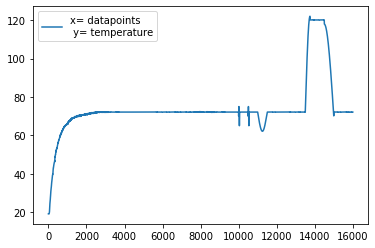

In [11]:
#plot the data 
plt.plot(data,label = 'x= datapoints \n y= temperature')
plt.legend()
plt.show()

In [12]:
train_data = data.iloc[:10000]
test_data = data.iloc[10000:]
train_data.shape, test_data.shape #returns (rows, columns)

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [13]:
### scale the data
#scaler = StandardScaler()
#scaler = scaler.fit(np.array(train_data).reshape(-1,1))
#train_data = scaler.transform(np.array(train_data).reshape(-1,1))
#test_data = scaler.transform(np.array(test_data).reshape(-1,1))


In [7]:
### create sequence

def create_sequences(dataset, time_steps=1):
    """
    Creates sequences from the input data with the given time steps
    """
    X_out = []
    y_out = []
    for i in range(len(dataset) - time_steps):
        X_out.append(dataset[i:i+time_steps])
        y_out.append(dataset[i+time_steps])
    return np.array(X_out), np.array(y_out)



In [8]:
# Assuming you have a single column univariate data called 'data'
# We can create sequences with a specified number of time steps using the create_sequences function
time_steps = 200

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

# Replace NaN values in X_train with 0
#X_train = np.nan_to_num(X_train, nan=0)
#y_train = np.nan_to_num(X_test, nan=0)
#X_test = np.nan_to_num(y_train, nan=0)
#y_test = np.nan_to_num(y_test, nan=0)


# output format (number of sequence, length of batches, number of features)
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

KeyError: 200

In [ ]:
# Define LSTM autoencoder model
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(time_steps, 1)))
#model.add(Dropout(rate=0.3))
model.add(RepeatVector(time_steps))
model.add(LSTM(64, activation='relu', return_sequences=True))
#model.add(Dropout(rate=0.3))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
#model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.0001), loss='mse')



In [9]:
#from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')


# Train the model and save the history
history = model.fit(X_train, X_train, epochs=32, batch_size=100, validation_data=(X_test, X_test), verbose=1,)


NameError: name 'model' is not defined

In [ ]:
### Plot Training - Validation loss
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();


In [13]:
# Make predictions on the train dataset
X_train_pred = model.predict(X_train, verbose=1)


307/307 [==============================] - 14s 46ms/step


In [16]:
# Calculate MAE loss on the train dataset
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)
# Flatten the train_mae_loss array
train_mae_loss = train_mae_loss.flatten()


ValueError: autodetected range of [nan, nan] is not finite

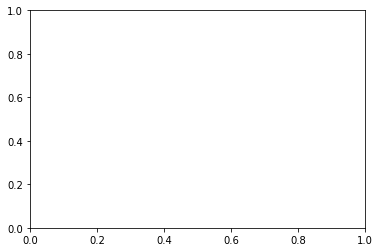

In [17]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

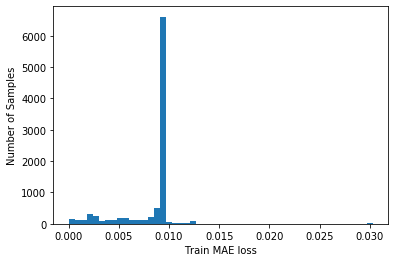

In [39]:
# Visualize MAE loss on the train dataset
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [40]:
# Make predictions on the test dataset
X_test_pred = model.predict(test_data, verbose=1)


200/200 [==============================] - 0s 851us/step


In [41]:
# Calculate MAE loss on the test dataset
test_mae_loss = np.mean(np.abs(X_test_pred - test_data), axis=1)


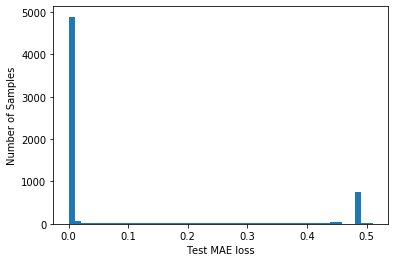

In [42]:
# Visualize MAE loss on the test dataset
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of Samples')
plt.show()

In [43]:
# Calculate the reconstruction error and define the threshold for anomaly detection
threshold = 0.01
error = np.mean(np.abs(X_test_pred - test_data), axis=1)


In [44]:
# Create a dataframe of the test dataset and anomaly detection results
df = pd.DataFrame({'data': test_data[:,0,0], 'error': error[:,0]})
df['loss'] = test_mae_loss
df['anomaly'] = df['error'] > threshold

# Set the threshold value for the test data, decided from test MAE histogram
threshold_value = 0.05

# Create a new column named "threshold" and set all values to threshold_value
num_samples = test_data.shape[0]
df['threshold'] = np.full(num_samples, threshold_value)

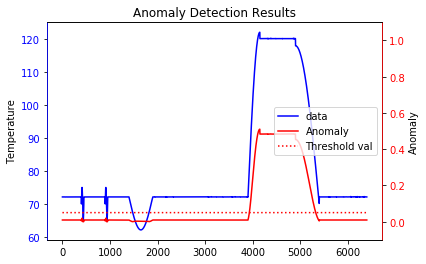

In [45]:
# Plot the anomaly dataframe and test dataset
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

color1 = 'blue'
color2 = 'red'

line1 = ax1.plot(df.index, df['data'], color=color1, label = 'data')
line2 = ax2.plot(df.index, df['loss'], color=color2, label = 'Anomaly')
line3 = ax2.plot(df.index, df['threshold'], color='red', linestyle = 'dotted', label = 'Threshold val')

ax2.set_ylim([-0.1, 1.1])
plt.title('Anomaly Detection Results')
plt.xlabel('Test data')
ax1.set_ylabel('Temperature')
ax2.set_ylabel('Anomaly')

ax2.spines['left'].set_color(color1)
ax2.spines['right'].set_color(color2)
ax1.tick_params(axis = 'y', labelcolor = color1)
ax2.tick_params(axis = 'y', labelcolor = color2)

lines = line1 + line2 + line3
labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc = "center right")

plt.show()


In [52]:
df.to_csv('file1.csv')

In [47]:
# Initialize variables for anomaly detection
window_size = 100
num_windows = int(len(test_data) / window_size)
consecutive_anomalies = 0

# Check each window of test data for anomalies
for i in range(num_windows):
    start_index = i * window_size
    end_index = start_index + window_size
    
    # Get the anomaly status for this window
    window_anomalies = df['anomaly'][start_index:end_index].values
    
    # Check if any anomalies were detected in this window
    if window_anomalies.sum() == 0:
        print(f"Window {i+1}: Normal Operation")
        consecutive_anomalies = 0
    else:
        print(f"Window {i+1}: Anomaly Detected")
        consecutive_anomalies += 1
        
        # Check if three consecutive windows had anomalies
        if consecutive_anomalies >= 3:
            print("Fault Detected!")
            consecutive_anomalies = 3

Window 1: Normal Operation
Window 2: Normal Operation
Window 3: Normal Operation
Window 4: Normal Operation
Window 5: Anomaly Detected
Window 6: Normal Operation
Window 7: Normal Operation
Window 8: Normal Operation
Window 9: Normal Operation
Window 10: Anomaly Detected
Window 11: Normal Operation
Window 12: Normal Operation
Window 13: Normal Operation
Window 14: Normal Operation
Window 15: Normal Operation
Window 16: Normal Operation
Window 17: Normal Operation
Window 18: Normal Operation
Window 19: Normal Operation
Window 20: Normal Operation
Window 21: Normal Operation
Window 22: Normal Operation
Window 23: Normal Operation
Window 24: Normal Operation
Window 25: Normal Operation
Window 26: Normal Operation
Window 27: Normal Operation
Window 28: Normal Operation
Window 29: Normal Operation
Window 30: Normal Operation
Window 31: Normal Operation
Window 32: Normal Operation
Window 33: Normal Operation
Window 34: Normal Operation
Window 35: Normal Operation
Window 36: Normal Operation
W